In [ ]:
# Import libraries
from pathlib import Path
from datetime import datetime, date
import warnings, math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import eikon as ek

## Authentication
Load the Eikon App Key from `api_key.txt`. This keeps credentials out of the code.


In [ ]:
# Plot style
plt.rcParams["figure.figsize"] = (11, 6)
plt.rcParams["axes.grid"] = True

# Quiet benign warnings from the Eikon lib
warnings.filterwarnings("ignore", category=FutureWarning, module="eikon")

# ---- Load App Key (adjacent file) ----
KEY_PATH = Path("api_key.txt")
if not KEY_PATH.exists():
    raise FileNotFoundError("api_key.txt not found. Create it with your App Key on a single line (no quotes).")
APP_KEY = KEY_PATH.read_text(encoding="utf-8").strip().strip('"').strip("'")
if not APP_KEY:
    raise RuntimeError("api_key.txt is empty. Put only the key on one line (no quotes).")
ek.set_app_key(APP_KEY)

print("Auth OK.")


## Helper functions
We use robust symbol resolution (e.g., resolving QQQ→QQQM when needed, trying `.P` ARCA venue, or TR.PrimaryRIC). For prices, we try `ek.get_timeseries` first and fall back to `ek.get_data` with `TR.PriceClose` if needed.


In [ ]:
# Number of trading days in a year (no weekends / holidays)
ANN = 252 

# Investment setup
START_INVEST = pd.Timestamp("2025-04-07")   # buy date for all scenarios
HIST_START   = "2024-01-01"  # enough history for MA(200)
END_DATE     = None

# Set assets
UNIVERSE_RAW = ["QQQ", "SPY", "SCHD", "VOO", "VTI"]
FORCE_SUB    = {"QQQ": "QQQM"}            # change/extend if you like
UNIVERSE     = [FORCE_SUB.get(s, s) for s in UNIVERSE_RAW]

# Cash models
HYSA_APY   = 0.035
DAILY_HYSA = (1 + HYSA_APY)**(1/365) - 1
DAILY_CASH = 0.0

def _to_datestr(x):
    if x is None: return None
    if isinstance(x, (pd.Timestamp, datetime, date)):
        return pd.Timestamp(x).strftime("%Y-%m-%d")
    return pd.Timestamp(x).strftime("%Y-%m-%d")

def _normalize_price_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.upper() for c in df.columns]
    if "CLOSE" in df.columns: return df
    if "VALUE" in df.columns: return df.rename(columns={"VALUE": "CLOSE"})
    # last resort: single numeric column
    num = [c for c in df.columns if df[c].dtype.kind in "fiu"]
    if len(num) == 1: return df.rename(columns={num[0]:"CLOSE"})
    raise KeyError(f"No obvious price column in {df.columns.tolist()}")

def _probe_id(instr: str, count=5, interval="daily") -> bool:
    try:
        ts = ek.get_timeseries(instr, count=count, interval=interval)
        return ts is not None and not ts.empty
    except Exception:
        return False

# Alias map (venue & sister-ETF variants)
_ALIAS = {
    "QQQ":   ["QQQ","QQQ.O","QQQ.OQ","QQQ.P","QQQM","QQQM.O","QQQM.OQ"],
    "QQQM":  ["QQQM","QQQM.O","QQQM.OQ","QQQM.P"],
    "SPY":   ["SPY","SPY.P"],
    "SCHD":  ["SCHD","SCHD.P"],
    "VOO":   ["VOO","VOO.P"],
    "VTI":   ["VTI","VTI.P"],
}

# Cache resolutions so we don’t spam the API
_RESOLVE_CACHE: dict[str, str | None] = {}

def resolve_symbol(sym: str) -> str | None:
    """Resolve a symbol -> working RIC via: as-is → TR.PrimaryRIC → '.P' → alias list."""
    if sym in _RESOLVE_CACHE:
        return _RESOLVE_CACHE[sym]
    out = None
    if _probe_id(sym):                       # already good?
        out = sym
    else:
        # Try TR symbology
        try:
            df, err = ek.get_data(sym, ["TR.PrimaryRIC","TR.RIC","TR.TradeVenueCode"], field_name=True)
            if err is None and df is not None and not df.empty:
                for col in ("TR.PrimaryRIC","TR.RIC"):
                    if col in df.columns:
                        ric = str(df[col].dropna().astype(str).iloc[0])
                        if ric and ric != "None" and _probe_id(ric):
                            out = ric
                            break
                if out is None and "TR.TradeVenueCode" in df.columns:
                    venue = str(df["TR.TradeVenueCode"].iloc[0]).upper()
                    if "ARCA" in venue:
                        p = f"{sym}.P"
                        if _probe_id(p): out = p
        except Exception:
            pass
        # Blind '.P'
        if out is None and sym.isalpha():
            p = f"{sym}.P"
            if _probe_id(p): out = p
        # Alias list
        if out is None:
            for cand in _ALIAS.get(sym, []):
                if _probe_id(cand):
                    out = cand
                    break
    _RESOLVE_CACHE[sym] = out
    return out

def resolve_list(symbols: list[str]) -> dict[str, str | None]:
    return {s: resolve_symbol(s) for s in symbols}

# Robust price pull: try get_timeseries; on failure fall back to get_data(TR.PriceClose) 
def _get_px_via_timeseries(ric: str, start, end) -> pd.Series:
    ts = ek.get_timeseries(ric, start_date=_to_datestr(start), end_date=_to_datestr(end), interval="daily")
    if ts is None or ts.empty:
        raise ValueError("empty")
    return _normalize_price_cols(ts)[["CLOSE"]].iloc[:,0].rename(ric)

def _get_px_via_getdata(ric: str, start, end) -> pd.Series:
    params = {"SDate": _to_datestr(start), "EDate": _to_datestr(end), "Frq": "D"}
    # request historical TR.PriceClose time series
    fields = [{ "TR.PriceClose": {"params": params} }]
    df, err = ek.get_data(ric, fields, field_name=True)
    if df is None or df.empty:
        raise ValueError("get_data returned empty")
    # Expect a 'Date' column + one numeric column
    if "Date" not in df.columns:
        # sometimes appears as 'DATE' or similar casing
        date_col = [c for c in df.columns if c.lower()=="date"]
        if date_col:
            df = df.rename(columns={date_col[0]:"Date"})
    val_cols = [c for c in df.columns if c not in ("Instrument","Date") and df[c].dtype.kind in "fiu"]
    if not val_cols:
        # try coercion
        for c in df.columns:
            if c not in ("Instrument","Date"):
                df[c] = pd.to_numeric(df[c], errors="coerce")
        val_cols = [c for c in df.columns if c not in ("Instrument","Date") and df[c].dtype.kind in "fiu"]
    if not val_cols:
        raise ValueError("no numeric value column in get_data result")
    out = df[["Date", val_cols[0]]].dropna()
    out["Date"] = pd.to_datetime(out["Date"])
    out = out.set_index("Date").sort_index().iloc[:,0].rename(ric)
    return out

def get_px(ric: str, start="2015-01-01", end=None) -> pd.Series:
    try:
        return _get_px_via_timeseries(ric, start, end)
    except Exception:
        # e.g., "Interval is not supported" → fall back to TR.PriceClose
        return _get_px_via_getdata(ric, start, end)

def get_many_px(rics, start="2015-01-01", end=None) -> pd.DataFrame:
    frames, seen = [], set()
    for r in rics:
        if r is None or r in seen: 
            continue
        seen.add(r)
        try:
            frames.append(get_px(r, start=start, end=end))
        except Exception as e:
            print(f"[skip] {r}: {e}")
    if not frames:
        raise RuntimeError("No price series pulled.")
    out = pd.concat(frames, axis=1).sort_index().ffill()
    out = out.loc[~out.index.duplicated(keep="first")]
    return out

def grow_cash(initial: float, index: pd.DatetimeIndex, daily_rate: float) -> pd.Series:
    days = (index - index[0]).days.values
    return pd.Series(initial * (1 + daily_rate)**days, index=index)

def daily_to_stats(v: pd.Series) -> pd.Series:
    r = v.pct_change().replace([np.inf, -np.inf], np.nan).dropna()
    if r.empty:
        return pd.Series({"CAGR":np.nan,"Ann.Vol":0.0,"Sharpe":np.nan,"MaxDD":0.0})
    curve = (1+r).cumprod()
    yrs = max(len(r)/ANN, 1e-9)
    cagr = curve.iloc[-1]**(1/yrs) - 1
    vol  = float(r.std()*np.sqrt(ANN))
    sharpe = np.nan if (vol==0 or np.isclose(vol,0.0)) else float((r.mean()/r.std())*np.sqrt(ANN))
    mdd = float((curve/curve.cummax()-1).min())
    return pd.Series({"CAGR":cagr,"Ann.Vol":vol,"Sharpe":sharpe,"MaxDD":mdd})

def perf_table_from_curves(curves: pd.DataFrame) -> pd.DataFrame:
    return curves.apply(daily_to_stats).T.sort_values("Sharpe", ascending=False)


In [ ]:
# %% [markdown]
# ## Resolve tickers → fetch prices → compute MA(50)/MA(200)  (robust)

# %%
# 1) Resolve
res_map = resolve_list(UNIVERSE)
print("Resolution map:")
for k in UNIVERSE:
    print(f"  {k:>6s} -> {res_map.get(k)}")

resolved = [ric for ric in res_map.values() if ric is not None]
if not resolved:
    raise RuntimeError("No tickers resolved. Check entitlements/connection.")

# 2) Fetch history wide enough for MAs (uses resilient get_px with get_data fallback)
px_all = get_many_px(resolved, start=HIST_START, end=END_DATE)

# 3) Slice to investing window & compute MAs on full history (with min_periods)
px   = px_all.loc[px_all.index >= START_INVEST].copy()
if px.empty:
    raise RuntimeError("No price data after START_INVEST; widen HIST_START or adjust date.")
ma50  = px_all.rolling(50,  min_periods=1).mean().loc[px.index]
ma200 = px_all.rolling(200, min_periods=1).mean().loc[px.index]

print("Fetched columns:", list(px.columns))


In [ ]:
# %% [markdown]
# ## Build portfolios
# - Cash_0: $1,000 at 0% (flat)
# - HYSA_3p5: $1,000 at 3.5% APY (daily comp)
# - Buy&Hold Basket: **$1,000 evenly across available names** on 2025-04-07
# - Signal Strategy: MA(50)>MA(200) filter; equal-weight passing names; idle cash earns HYSA

# %%
idx = px.index

# 1) Cash buckets
cash_0 = grow_cash(1000.0, idx, DAILY_CASH).rename("Cash_0")
cash_h = grow_cash(1000.0, idx, DAILY_HYSA).rename("HYSA_3p5")

# 2) Buy & Hold basket — evenly split the $1,000 across *available* names
available_syms = [sym for sym in UNIVERSE if (res_map.get(sym) in px.columns)]
if not available_syms:
    raise RuntimeError("None of the UNIVERSE tickers are available in px; check entitlements.")
each_alloc = 1000.0 / len(available_syms)

bh_values, bh_shares = {}, {}
for sym in available_syms:
    rid = res_map[sym]
    s = px[rid].dropna()
    pos = s.index.get_indexer([START_INVEST], method="nearest")[0]
    buy_dt = s.index[pos]
    buy_px = float(s.iloc[pos])
    shares = each_alloc / buy_px
    bh_shares[sym] = (buy_dt, buy_px, shares)
    v = (px[rid] * shares).copy()
    v.loc[v.index < buy_dt] = 0.0
    bh_values[sym] = v.rename(sym)

bh_df = pd.DataFrame(bh_values) if bh_values else pd.DataFrame(index=idx)
bh_total = bh_df.sum(axis=1).rename("BH_Combined").reindex(idx).ffill().fillna(0.0)

# 3) Signal Strategy: MA(50)>MA(200); equal-weight passing; idle portion → HYSA
pass_mask = (ma50[px.columns] > ma200[px.columns]).reindex(idx).fillna(False)
weights = pd.DataFrame(0.0, index=idx, columns=px.columns)
for dt, row in pass_mask.iterrows():
    passing = row[row].index.tolist()
    if passing:
        w = 1.0 / len(passing)
        weights.loc[dt, passing] = w

rets = px.pct_change().fillna(0.0)
sig_rets_only = (weights * rets).sum(axis=1)

w_sum = weights.sum(axis=1)
idle = (1.0 - w_sum).clip(lower=0.0)
sig_total_ret = sig_rets_only + idle * DAILY_HYSA

sig_curve = (1 + sig_total_ret).cumprod() * 1000.0
sig_curve.name = "Signal_EQW_MA"

# 4) Collect valuation curves
curves = pd.concat([cash_0, cash_h, bh_total, sig_curve], axis=1).astype(float)
curves.tail()


In [ ]:
# %% [markdown]
# ## Performance & Visuals

# %%
stats = perf_table_from_curves(curves)
display(stats.style.format({"CAGR":"{:.2%}","Ann.Vol":"{:.2%}","Sharpe":"{:.2f}","MaxDD":"{:.2%}"}))

curves.plot(title="Value of $1,000 from 2025-04-07 — Cash vs HYSA vs Buy&Hold vs Signal")
plt.ylabel("USD")
plt.show()

final_vals = curves.iloc[-1].sort_values(ascending=False)
final_vals.plot(kind="bar", title=f"Final Portfolio Values as of {curves.index[-1].date()}")
plt.ylabel("USD")
plt.show()

# Optional: inspect the Buy&Hold components
if 'bh_df' in globals() and not bh_df.empty:
    (bh_df.join(bh_total)).plot(title="Buy & Hold components (even allocation of $1,000)")
    plt.ylabel("USD")
    plt.show()

# Optional: see the exact buy prices & shares used
if bh_shares:
    print("\nBuy & Hold entry snapshot (nearest to 2025-04-07):")
    for sym, (dt, px0, sh) in bh_shares.items():
        print(f"  {sym:<5s}  date={dt.date()}  price=${px0:,.2f}  shares={sh:.4f}")


# Portfolio Strategy: Cash vs HYSA vs Buy & Hold vs MA‑Signal

**Objective:** Compare how \$1,000 grows from a chosen start date under four approaches, showcasing the importance of Time Value of Money:

- **Cash_0** – held at 0% (flat). Typical banks that'll return a penny
- **HYSA_3p5** – high‑yield savings at **3.5% APY** (e.g AMEX)  
- **BH_Combined** – **buy & hold** an equal‑weight basket of ETFs (even split)  
- **Signal_EQW_MA** – simple **50/200‑day moving‑average** filter per asset; equal‑weight across passing assets; idle cash earns HYSA.

**Data Extraction:** Refinitiv Workspace/Eikon via the `eikon` Python library w/ its respective API Key.  
I saved my Eikon App Key in a file named **`api_key.txt`**

**Expectations**: Due to the Time Value of Money, assuming the same quantity of money, it will be worth more today than in the future due to the possible investment opportunities or macroeconomic factors (such as inflation)

**Hypothesis**: The buy/hold strategy of ETFs will be the best strategy for most people due to lower risk and reliable returns as opposed to other strategies that either have more risk or way less returns

In [1]:
# Import Libraries
import warnings, math, os
from pathlib import Path
from datetime import datetime, date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import eikon as ek
from pathlib import Path


In [2]:
# Plot style
plt.rcParams["figure.figsize"] = (11, 6)
plt.rcParams["axes.grid"] = True

ANN = 252  # trading days per year

# Initial Investment Parameters
START_INVEST = pd.Timestamp("2025-04-07")  # buy date for all scenarios
HIST_START   = "2023-01-01"                # enough history for MA(200)
END_DATE     = None

# Universe — the resolver can swap QQQ → QQQM if needed
UNIVERSE_RAW = ["QQQ", "SPY", "VOO", "VTI", "SCHD"]
FORCE_SUB    = {"QQQ": "QQQM"}  # extend as needed

# Cash models
HYSA_APY   = 0.035
DAILY_HYSA = (1 + HYSA_APY)**(1/365) - 1

# Asset pruning
MIN_DAYS_AFTER_START = 30  # drop assets with too little data after START


## Authentication
Load the Eikon App Key from `api_key.txt`. This is in my gitignore lol


In [4]:
#  Load App Key 
KEY_PATH = Path("api_key.txt")
if not KEY_PATH.exists():
    raise FileNotFoundError("api_key.txt not found. Create it with your App Key on a single line (no quotes).")
APP_KEY = KEY_PATH.read_text(encoding="utf-8").strip().strip('"').strip("'")
if not APP_KEY:
    raise RuntimeError("api_key.txt is empty. Put only the key on one line (no quotes).")
ek.set_app_key(APP_KEY)

# Quiet benign warnings from the Eikon lib
warnings.filterwarnings("ignore", category=FutureWarning, module="eikon")

print("Auth OK.")


Auth OK.


## Helper functions
We use robust symbol resolution (e.g., resolving QQQ→QQQM when needed, trying `.P` ARCA venue, or TR.PrimaryRIC). For prices, we try `ek.get_timeseries` first and fall back to `ek.get_data` with `TR.PriceClose` if needed.


In [6]:
#  Helpers (resolver, robust downloads, returns, perf) 
def _to_datestr(x):
    if x is None: return None
    if isinstance(x, (pd.Timestamp, datetime, date)):
        return pd.Timestamp(x).strftime("%Y-%m-%d")
    return pd.Timestamp(x).strftime("%Y-%m-%d")

def _normalize_price_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.upper() for c in df.columns]
    if "CLOSE" in df.columns: return df
    if "VALUE" in df.columns: return df.rename(columns={"VALUE":"CLOSE"})
    num = [c for c in df.columns if df[c].dtype.kind in "fiu"]
    if len(num) == 1: return df.rename(columns={num[0]:"CLOSE"})
    raise KeyError(f"No obvious price column in {df.columns.tolist()}")

def _probe_id(instr: str, count=5, interval="daily") -> bool:
    try:
        ts = ek.get_timeseries(instr, count=count, interval=interval)
        return ts is not None and not ts.empty
    except Exception:
        return False

# Alias map (venue & sister-ETF variants)
_ALIAS = {
    "QQQ":  ["QQQ","QQQ.O","QQQ.OQ","QQQ.P","QQQM","QQQM.O","QQQM.OQ"],
    "QQQM": ["QQQM","QQQM.O","QQQM.OQ","QQQM.P"],
    "SPY":  ["SPY","SPY.P"],
    "SCHD": ["SCHD","SCHD.P"],
    "VOO":  ["VOO","VOO.P"],
    "VTI":  ["VTI","VTI.P"],
}

# Cache resolution
_RESOLVE_CACHE = {}

def resolve_symbol(sym: str) -> str | None:
    if sym in _RESOLVE_CACHE:
        return _RESOLVE_CACHE[sym]
    out = None
    if _probe_id(sym):
        out = sym
    else:
        try:
            df, err = ek.get_data(sym, ["TR.PrimaryRIC","TR.RIC","TR.TradeVenueCode"], field_name=True)
            if err is None and df is not None and not df.empty:
                for col in ("TR.PrimaryRIC","TR.RIC"):
                    if col in df.columns:
                        ric = str(df[col].dropna().astype(str).iloc[0])
                        if ric and ric != "None" and _probe_id(ric):
                            out = ric
                            break
                if out is None and "TR.TradeVenueCode" in df.columns:
                    venue = str(df["TR.TradeVenueCode"].iloc[0]).upper()
                    if "ARCA" in venue:
                        p = f"{sym}.P"
                        if _probe_id(p): out = p
        except Exception:
            pass
        if out is None and sym.isalpha():
            p = f"{sym}.P"
            if _probe_id(p): out = p
        if out is None:
            for cand in _ALIAS.get(sym, []):
                if _probe_id(cand):
                    out = cand
                    break
    _RESOLVE_CACHE[sym] = out
    return out

def resolve_list(symbols: list[str]) -> dict[str, str | None]:
    return {s: resolve_symbol(s) for s in symbols}

def _get_px_via_timeseries(ric: str, start, end) -> pd.Series:
    ts = ek.get_timeseries(ric, start_date=_to_datestr(start), end_date=_to_datestr(end), interval="daily")
    if ts is None or ts.empty:
        raise ValueError("empty")
    return _normalize_price_cols(ts)[["CLOSE"]].iloc[:,0].rename(ric)

def _get_px_via_getdata(ric: str, start, end) -> pd.Series:
    params = {"SDate": _to_datestr(start), "EDate": _to_datestr(end), "Frq":"D"}
    fields = [{"TR.PriceClose": {"params": params}}]
    df, err = ek.get_data(ric, fields, field_name=True)
    if df is None or df.empty:
        raise ValueError("get_data returned empty")

    # Robust 'Date' extraction
    date_col = None
    for cand in df.columns:
        if str(cand).strip().lower() == "date":
            date_col = cand; break
    if date_col is None and df.index.name and str(df.index.name).strip().lower()=="date":
        df = df.reset_index(); date_col = "index"
    if date_col is None:
        for cand in df.columns:
            if "date" in str(cand).lower():
                date_col = cand; break
    if date_col is None:
        raise ValueError("No 'Date' column in get_data result.")

    val_cols = [c for c in df.columns if c not in (date_col,"Instrument") and pd.api.types.is_numeric_dtype(df[c])]
    if not val_cols:
        for c in df.columns:
            if c not in (date_col,"Instrument"):
                df[c] = pd.to_numeric(df[c], errors="coerce")
        val_cols = [c for c in df.columns if c not in (date_col,"Instrument") and pd.api.types.is_numeric_dtype(df[c])]
    if not val_cols:
        raise ValueError("No numeric price column in get_data result.")

    out = df[[date_col, val_cols[0]]].dropna()
    out[date_col] = pd.to_datetime(out[date_col])
    out = out.set_index(date_col).sort_index().iloc[:,0].rename(ric)
    return out

def get_px(ric: str, start="2015-01-01", end=None) -> pd.Series:
    try:
        return _get_px_via_timeseries(ric, start, end)
    except Exception:
        return _get_px_via_getdata(ric, start, end)

def get_many_px(rics, start="2015-01-01", end=None) -> pd.DataFrame:
    frames, seen = [], set()
    for r in rics:
        if r is None or r in seen:
            continue
        seen.add(r)
        try:
            s = get_px(r, start=start, end=end)
            if s is None or s.empty:
                print(f"[drop] {r}: empty series"); continue
            frames.append(s)
        except Exception as e:
            print(f"[drop] {r}: {e}")
    if not frames:
        raise RuntimeError("No price series pulled.")
    out = pd.concat(frames, axis=1).sort_index().ffill()
    out = out.loc[~out.index.duplicated(keep='first')]
    return out

def grow_cash(initial: float, index: pd.DatetimeIndex, daily_rate: float) -> pd.Series:
    days = (index - index[0]).days.values
    return pd.Series(initial * (1 + daily_rate)**days, index=index)

def daily_to_stats(v: pd.Series) -> pd.Series:
    r = v.pct_change().replace([np.inf, -np.inf], np.nan).dropna()
    if r.empty:
        return pd.Series({"CAGR":np.nan,"Ann.Vol":0.0,"Sharpe":np.nan,"MaxDD":0.0})
    curve = (1+r).cumprod()
    yrs = max(len(r)/ANN, 1e-9)
    cagr = curve.iloc[-1]**(1/yrs) - 1
    vol  = float(r.std()*np.sqrt(ANN))
    sharpe = np.nan if (vol==0 or np.isclose(vol,0.0)) else float((r.mean()/r.std())*np.sqrt(ANN))
    mdd = float((curve/curve.cummax()-1).min())
    return pd.Series({"CAGR":cagr,"Ann.Vol":vol,"Sharpe":sharpe,"MaxDD":mdd})

def perf_table_from_curves(curves: pd.DataFrame) -> pd.DataFrame:
    return curves.apply(daily_to_stats).T.sort_values("Sharpe", ascending=False)


## Fetch prices → prune bad assets
- Resolve the universe to working identifiers
- Download daily closes (robustly) from Eikon
- **Drop** assets that are empty or that have insufficient data after the start date


In [8]:
#  Resolve → fetch 
UNIVERSE = [FORCE_SUB.get(s, s) for s in UNIVERSE_RAW]

res_map = resolve_list(UNIVERSE)
resolved = [ric for ric in res_map.values() if ric is not None]
if not resolved:
    raise RuntimeError("No tickers resolved. Check entitlements/connection.")

px_all = get_many_px(resolved, start=HIST_START, end=END_DATE)

# Slice to investing window and prune weak assets
px = px_all.loc[px_all.index >= START_INVEST].copy()
valid_cols = []
for c in list(px.columns):
    s = px[c].dropna()
    if s.empty:
        print(f"[drop] {c}: no data after start date"); continue
    if (s.index[-1] - s.index[0]).days < MIN_DAYS_AFTER_START:
        print(f"[drop] {c}: too little data after start date"); continue
    valid_cols.append(c)

px = px[valid_cols]
px_all = px_all[valid_cols]

if px.empty or not valid_cols:
    raise RuntimeError("All assets were dropped; nothing to backtest.")

print("Final universe:", valid_cols)


2025-08-19 16:19:44,675 P[11032] [MainThread 32428] Error with QQQM: Interval is not supported
2025-08-19 16:19:44,690 P[11032] [MainThread 32428] QQQM: Interval is not supported | 
2025-08-19 16:19:47,230 P[11032] [MainThread 32428] Error with SCHD: Invalid RIC
2025-08-19 16:19:47,230 P[11032] [MainThread 32428] SCHD: Invalid RIC | 


Final universe: ['QQQM.O', 'SPY', 'VOO', 'VTI', 'SCHD.P']


## Build portfolios
- **Cash_0:** \$1,000 at 0%  
- **HYSA_3p5:** \$1,000 at 3.5% APY (daily)  
- **Buy & Hold:** equal‑weight across available assets at the start date  
- **Signal:** MA(50)>MA(200) per asset with strict `min_periods` to avoid look‑ahead; equal‑weight across passing assets; idle cash earns the HYSA rate


In [10]:
# Build portfolios 
idx = px.index
cash_0 = grow_cash(1000.0, idx, 0.0).rename("Cash_0")
cash_h = grow_cash(1000.0, idx, DAILY_HYSA).rename("HYSA_3p5")

# Buy & Hold across available columns (not original tickers)
bh_values, bh_shares = {}, {}
each_alloc = 1000.0 / len(px.columns)

for ric in px.columns:
    s = px[ric].dropna()
    pos = s.index.get_indexer([START_INVEST], method="nearest")[0]
    buy_dt = s.index[pos]
    buy_px = float(s.iloc[pos])
    shares = each_alloc / buy_px
    bh_shares[ric] = (buy_dt, buy_px, shares)
    v = (px[ric] * shares).copy()
    v.loc[v.index < buy_dt] = 0.0
    bh_values[ric] = v.rename(ric)

bh_df = pd.DataFrame(bh_values) if bh_values else pd.DataFrame(index=idx)
bh_total = bh_df.sum(axis=1).rename("BH_Combined").reindex(idx).ffill().fillna(0.0)

# MA(50/200) with strict min_periods to avoid look-ahead
ma50  = px_all.rolling(50,  min_periods=50).mean().loc[idx]
ma200 = px_all.rolling(200, min_periods=200).mean().loc[idx]

pass_mask = (ma50[px.columns] > ma200[px.columns]).reindex(idx).fillna(False)
weights = pd.DataFrame(0.0, index=idx, columns=px.columns)
for dt, row in pass_mask.iterrows():
    passing = row[row].index.tolist()
    if passing:
        w = 1.0 / len(passing)
        weights.loc[dt, passing] = w

rets = px.pct_change().fillna(0.0)
sig_rets_only = (weights * rets).sum(axis=1)

w_sum = weights.sum(axis=1)
idle = (1.0 - w_sum).clip(lower=0.0)
sig_total_ret = sig_rets_only + idle * DAILY_HYSA
sig_curve = (1 + sig_total_ret).cumprod() * 1000.0
sig_curve.name = "Signal_EQW_MA"

curves = pd.concat([cash_0, cash_h, bh_total, sig_curve], axis=1).astype(float)
curves.tail()


,Cash_0,HYSA_3p5,BH_Combined,Signal_EQW_MA
Date,,,,
2025-08-13,1000.0,1012.137126,1262.037230,1157.094240
2025-08-14,1000.0,1012.232525,1260.477070,1156.437710
2025-08-15,1000.0,1012.327933,1257.466793,1153.214651
2025-08-18,1000.0,1012.614211,1256.764551,1153.061846
2025-08-19,1000.0,1012.709655,1250.281382,1144.280250


## Performance & visuals
We compute annualized **CAGR**, **volatility**, **Sharpe** (rf≈0), and **max drawdown**, and
plot valuation curves, final values, and buy‑&‑hold components.


In [12]:
# Risk-free = actual HYSA daily return (so HYSA Sharpe ≈ 0 by construction)
rf_series = curves["HYSA_3p5"].pct_change().replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Daily returns and excess returns over rf
rets   = curves.pct_change().replace([np.inf, -np.inf], np.nan)
excess = rets.sub(rf_series, axis=0)

# Sharpe per strategy (robust to zero variance); show Cash_0 = 0 by convention
std = excess.std(ddof=0).replace(0, np.nan)
sharpe = (excess.mean() / std * np.sqrt(ANN)).rename("Sharpe")
sharpe.loc["HYSA_3p5"] = 0.0   # rf vs itself
sharpe.loc["Cash_0"]   = 0.0   # baseline convention

order = ["BH_Combined", "Signal_EQW_MA", "HYSA_3p5", "Cash_0"]

# Display Sharpe
display(sharpe.reindex(order).to_frame()
        .style.format("{:.2f}")
        .set_caption("Sharpe (excess over HYSA)"))

# Display total % return since start (from $1,000)
total_ret = (curves.iloc[-1] / curves.iloc[0] - 1.0).rename("Total Return")
display(total_ret.reindex(order).to_frame()
        .style.format("{:.2%}")
        .set_caption(f"Total Return since {START_INVEST.date()}"))


,Sharpe
BH_Combined,2.74
Signal_EQW_MA,1.77
HYSA_3p5,0.00
Cash_0,0.00


,Total Return
BH_Combined,25.03%
Signal_EQW_MA,14.43%
HYSA_3p5,1.27%
Cash_0,0.00%


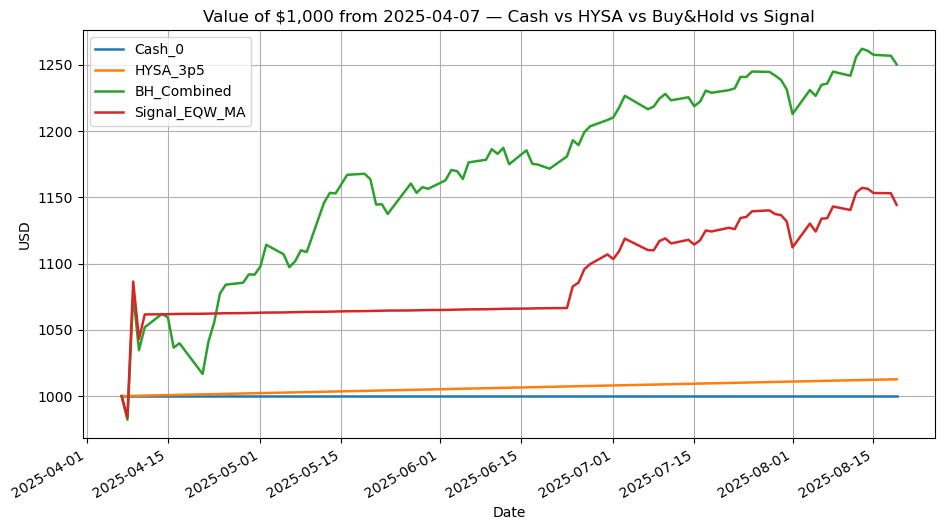

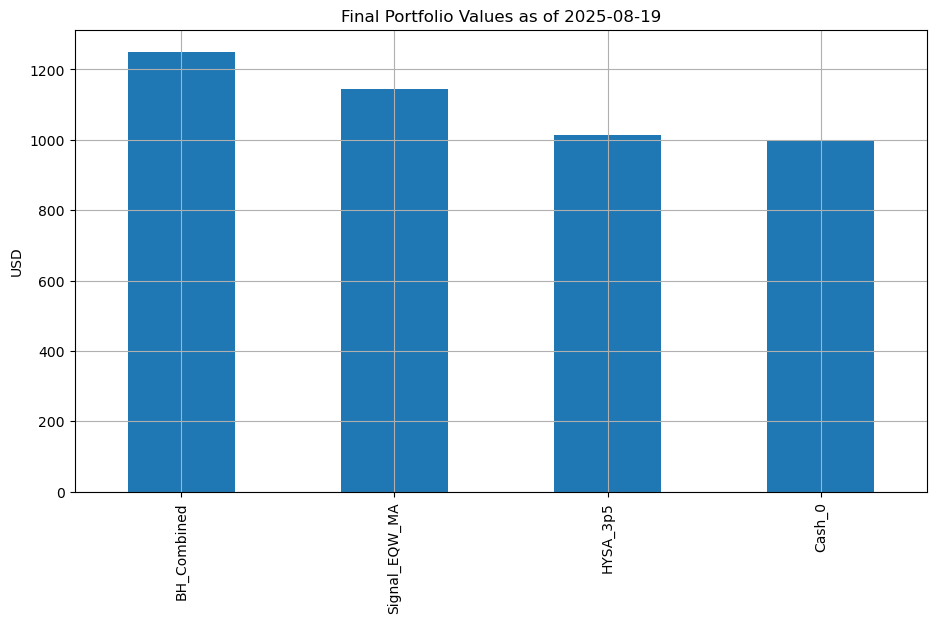

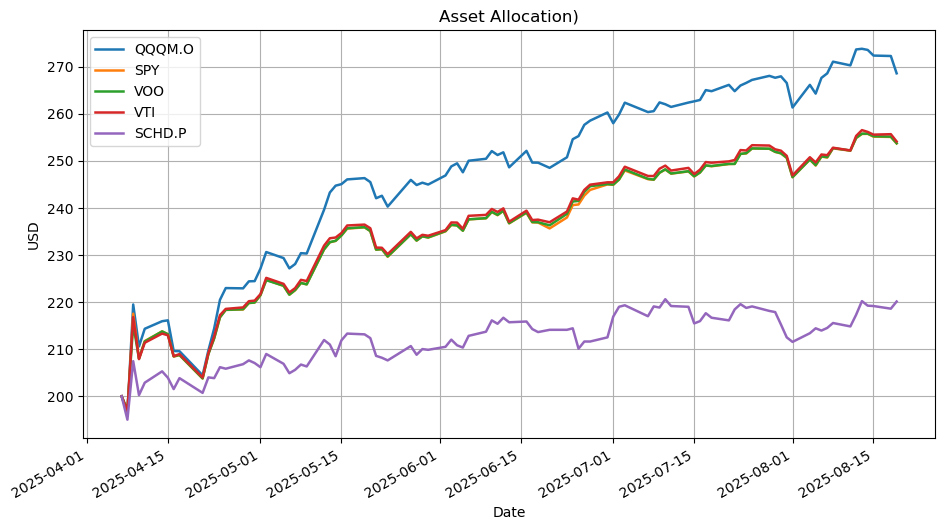

In [23]:
# 1) Portfolio value curves
ax = curves.plot(lw=1.8, title=f"Value of $1,000 from {START_INVEST.date()} — Cash vs HYSA vs Buy&Hold vs Signal")
ax.set_ylabel("USD"); ax.set_xlabel("Date"); plt.gcf().autofmt_xdate(); plt.show()

# 2) Final values bar
ax = curves.iloc[-1].sort_values(ascending=False).plot(kind="bar",
      title=f"Final Portfolio Values as of {curves.index[-1].date()}")
ax.set_ylabel("USD"); plt.show()

# 3) Buy & Hold components only (no BH_Combined in the plot)
if 'bh_df' in globals() and not bh_df.empty:
    ax = bh_df.plot(lw=1.8, title="Asset Allocation)")
    ax.set_ylabel("USD"); ax.set_xlabel("Date"); plt.gcf().autofmt_xdate(); plt.show()


# 📊 Conclusion

## Results Overview
- **Buy & Hold (BH_Combined):**  
  Delivered the highest total return (+25.03%) since April 2025. Strong growth overall going w/ ETFs.  
  Sharpe Ratio: **2.74** (best balance of risk and return).

- **Signal Strategy (EQW MA Crossover):**  
  Produced moderate gains (+14.43%). Sharpe Ratio of **1.77** shows decent risk-adjusted performance, though lower than Buy & Hold.

- **HYSA (3.5% APY):**  
  Stable and predictable return (+1.27%), but Sharpe is set to **0.00** since HYSA is used as the risk-free baseline.

- **Cash (0%):**  
  Flat value, Sharpe = **0.00**, no growth. Although I guess it can be argued it could be less since again due to Time Value of Money, money is worth less now and is obviously not beating the market hence a potential negative value?

---

## Conclusion
- **Buy & Hold dominates** in both absolute returns and Sharpe ratio, outperforming the signal strategy and safe assets.  
- **Signal strategy** provides a smoother ride with less drawdown than Buy & Hold, but sacrifices upside.  
- **HYSA** is low risk, low reward—best only for safety.  
- **Cash** is not productive compared to all other options.

---

## Limitations & Future Plans
- **Short horizon**: Results only span April–Aug 2025. Longer backtests are needed.  
- **Universe is limited**: Only 5 ETFs/stocks; expanding to bonds, commodities, or international markets may improve diversification.  
- **Signal is basic (MA crossover)**: Testing advanced strategies (momentum, risk parity, volatility targeting) could yield better outcomes.  
- **Transaction costs & taxes** not considered—would reduce active strategy returns.  

👉 **Next Steps**: Extend backtest period, broaden asset universe, refine trading signals, and include costs for realism.
